## Time Dependent Gillespie Algorithm

In this notebook, we provide a numerical implementation of our Gillespie Algorithm, for two contact rate models. The first considers a simple exponential rate (which is not used in the report) and a cyclical contact rate which is used.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

## 1 - Exponential Decay Contact Rate Model (Not used in report)
Please see the notebook titled `"exponential_contact_mode.ipynb"` for implementation of the exponential model that is discussed in our report.

Here we consider the contact rate:
$$
B(t) = Ae^{-\alpha t}
$$

In [150]:
def exponential_rate(t, A, a):
    return A*np.exp(-a*t)


def basic_rate(t, A):
    return A


def cosine_rate(t, A, a):
    return A + a*np.cos(t)

In [151]:
from scipy import optimize
import time

def exp_time_dependent_gillespie(tspan, X_0, f1_values, f2_values):
    
    
    def exp_contact_rate(t, A, a):
        return A*np.exp(-a*t)
    
    
    def solve_new_time(t, X, f1_values, f2_values, r):
        A = f1_values[0]
        a = f1_values[1]
        def f(x):
            return f2_values*X[1]*x + X[0]*X[1]*A*np.exp(-a*t)*(1 - np.exp(-a*x))/(N*a) - np.log(1/r)
        return optimize.broyden1(f, [0.2], f_tol=1e-10)[0]
    
    
    def calc_propensities(t, X, N, f1_values, f2_values):
        
        # a_1: S + I -> I + I    w/ rate B(t)*S*I/N
        a1 = X[0]*X[1]*exp_contact_rate(t, f1_values[0], f1_values[1])/N
        
        # a_2: I -> R w/ rate gamma*I
        a2 = f2_values*X[1]
        
        return np.sum([a1, a2]), [a1, a2]
    
    counter = 0
    t_0, t_final = tspan
    N = np.sum(X_0)
    S = X_0[0]
    I = X_0[1]
    R = X_0[2]
    
    S_hist = [S]
    I_hist = [I]
    R_hist = [R]
    t_hist = [t_0]
    
    t = t_0
    X = X_0
    
    prop_func = {}
    prop_func[0] = np.array((-1,1,0))   # S + I -> I + I
    prop_func[1] = np.array((0,-1,1))   # I -> R
    
    
    while t < t_final:
        
        # generate new time
        r  = np.random.rand()
        delta = solve_new_time(t, X, f1_values, f2_values, r)
        t = t + delta
        
        # calculate_propensities for updated time step
        a_0, a_list = calc_propensities(t, X, N, f1_values, f2_values)
        
        # choosing the reaction
        r = np.random.rand()
        a_list = a_list / a_0
        
        for k in range(len(a_list)):
            if a_list[k] > r:
                # reaction k chosen
                break
            else:
                # reaction not chosen
                pass
        X = X + prop_func[k]
        
        # record update
        S_hist.append(X[0])
        I_hist.append(X[1])
        R_hist.append(X[2])
        t_hist.append(t)
        counter += 1
        # check for extinction
        
        if X[1] == 0 :
            break
            
    print("="*50)
    print(" Basic Next Reaction Method for SIR Model")
    print(" Reaction 1: S + I -> I + I, with rate " + str(f1_values))
    print(" Reaction 2:     I -> R    , with rate " + str(f2_values))
    print(" Total Number of Iterations in Simulation: " + str(counter))
    print("="*50)
    return S_hist, I_hist, R_hist, np.asarray(t_hist)

In [152]:
S_hist, I_hist, R_hist, t_hist = exp_time_dependent_gillespie([0,20], [4999, 1, 0], [6, 0.2], 1)

 Basic Next Reaction Method for SIR Model
 Reaction 1: S + I -> I + I, with rate [6, 0.2]
 Reaction 2:     I -> R    , with rate 1
 Total Number of Iterations in Simulation: 8933


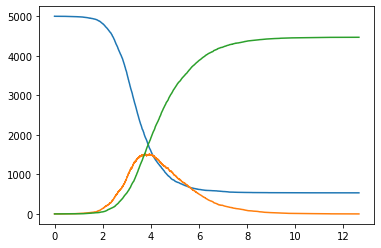

In [153]:
plt.plot(t_hist, S_hist)
plt.plot(t_hist, I_hist)
plt.plot(t_hist, R_hist)

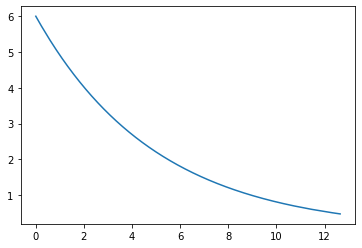

In [154]:
plt.plot(t_hist, 6*np.exp(-0.2*t_hist))

## 2 - Cosine Contact Rate Model (Used in report)
Please see the notebook titled `"cosine_contact_model.ipynb"` for further discussion and analysis.

$$
B(t) = A + B\cos(t)
$$

In [155]:
def cos_time_dependent_gillespie(tspan, X_0, f1_values, f2_values):
    
    
    def cos_contact_rate(t, A, a):
        return A + a*np.cos(t)
    
    
    def solve_new_time(t, X, f1_values, f2_values, r):
        A = f1_values[0]
        a = f1_values[1]
        def f(x):
            return f2_values*X[1]*x + (A*x + a*(np.sin(t)*np.cos(x) + np.sin(x)*np.cos(t) - np.sin(t)))*X[0]*X[1]/N - np.log(1/r)
        return optimize.diagbroyden(f, [0.2], f_tol=1e-10)[0]
    
    
    def calc_propensities(t, X, N, f1_values, f2_values):
        
        # a_1: S + I -> I + I    w/ rate B(t)*S*I/N
        a1 = X[0]*X[1]*cos_contact_rate(t, f1_values[0], f1_values[1])/N
        
        # a_2: I -> R w/ rate gamma*I
        a2 = f2_values*X[1]
        return np.sum([a1, a2]), [a1, a2]
    
    counter = 0
    t_0, t_final = tspan
    N = np.sum(X_0)
    S = X_0[0]
    I = X_0[1]
    R = X_0[2]
    
    S_hist = [S]
    I_hist = [I]
    R_hist = [R]
    t_hist = [t_0]
    
    ss1 = []
    ss2 = []
    ss3 = []
    
    t = t_0
    X = X_0
    
    prop_func = {}
    prop_func[0] = np.array((-1,1,0))   # S + I -> I + I
    prop_func[1] = np.array((0,-1,1))   # I -> R
    
    
    while t < t_final:
        
        # generate new time
        
        r  = np.random.rand()
        delta = solve_new_time(t, X, f1_values, f2_values, r)
        t = t + delta
        
        # calculate_propensities for updated time step

        a_0, a_list = calc_propensities(t, X, N, f1_values, f2_values)
        
        # choosing the reaction
        
        r = np.random.rand()
        a_list = a_list / a_0
        
        for k in range(len(a_list)):
            if a_list[k] > r:
                # reaction k chosen
                break
            else:
                # reaction not chosen
                pass
            
        X = X + prop_func[k] # perform the reaction
        
        # record update
        S_hist.append(X[0])
        I_hist.append(X[1])
        R_hist.append(X[2])
        t_hist.append(t)
        counter += 1
        # check for extinction
        
        if X[1] == 0 :
            break
    return S_hist, I_hist, R_hist, np.asarray(t_hist)

In [156]:
t_sim = 0
while t_sim < 1:
    # find major epidemic - takes longer than 1 second to compute unlike a non-major epidemic
    start = time.time()
    S, I, R, t = cos_time_dependent_gillespie([0, 100], [4999, 1, 0], [1.4, 1], 1)
    end = time.time()
    t_sim = end - start

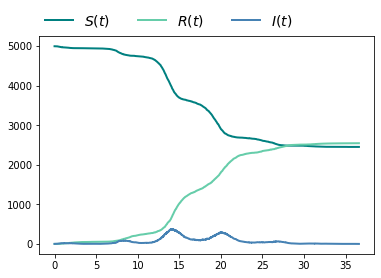

In [158]:
fig, ax = plt.subplots()
ax.plot(t, S, label = "$S(t)$", linewidth = 2, color = "teal")
ax.plot(t, R, label = "$R(t)$", linewidth = 2, color = "mediumaquamarine")
ax.plot(t, I, label = "$I(t)$", linewidth = 2, color = "steelblue")
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
            borderaxespad=0, frameon=False, fontsize = 14)

In [157]:
# saving the data for creating later figures

import pickle

with open("data/s_sample_cosine.pkl", "wb") as f:
    pickle.dump(S, f)
    
with open("data/i_sample_cosine.pkl", "wb") as f:
    pickle.dump(I, f)
    
with open("data/r_sample_cosine.pkl", "wb") as f:
    pickle.dump(R, f)
    
with open("data/t_sample_cosine.pkl", "wb") as f:
    pickle.dump(t, f)

In [ ]:
# performing many simulations for many different infective introduction times

#############################################################################################
"""
WARNING 
    - Takes a long time to run due to solver.
    - Produces a lot of data
    - Not optimal for sole purpose of looking at epidemic prob as gives full event history
"""          
#############################################################################################

# this code was copied to Google Colab and run there due to better runtime.

import time
import pickle

start = time.time()


t_list = np.linspace(0, 20, 10)

t_hist = {}

counter = 17
for t_0 in t_list:
    # test different R_0 values
    
    t_hist[t_0] = {}
    t_hists = {}
    S_hists = {}
    I_hists = {}
    R_hists = {}
    
    for i in range(100):
        S, I, R, t = cos_time_dependent_gillespie([t_0, 100 + t_0], [9999, 1, 0], [1.4, 1], 1)
        t_hists[i] = t
        S_hists[i] = S
        I_hists[i] = I
        R_hists[i] = R
        
    fname_S = "s_hist_1.4_0.3_1000_counter_" + str(counter)+  ".pickle"
    fname_I = "i_hist_1.4_0.3_1000_counter_" + str(counter)+  ".pickle"
    fname_R = "r_hist_1.4_0.3_1000_counter_" + str(counter)+  ".pickle"
    fname_t = "t_hist_1.4_0.3_1000_counter_" + str(counter)+  ".pickle"
    
    
    with open("data/" + fname_S, "wb") as f:
        pickle.dump(S_hists, f)
    
    with open("data/" + fname_I, "wb") as f:
        pickle.dump(I_hists, f)
        
    with open("data/" + fname_R, "wb") as f:
        pickle.dump(R_hists, f)
        
    with open("data/" + fname_t, "wb") as f:
        pickle.dump(t_hists, f)
    
        
    t_hist[t_0]["S"] = S_hists
    t_hist[t_0]["I"] = I_hists
    t_hist[t_0]["R"] = R_hists
    t_hist[t_0]["t"] = t_hists
    counter+=1
    
    print("Completed t="+str(t_0))
end = time.time()

print("Completed in :" + str(end - start))

In [ ]:
# Finding lineages which we classify as Major Epidemics vs Minor

# We say an epidemic is Major if the total number of infected over the duration of the epidemic was more than 20. 


major_epi = {}
major_epi_threshold = 15

for t_0 in t_list:
    major_epi[t_0] = []
    for i in range(len(t_hist[t_0]["R"])):
        total_infec = t_hist[t_0]["R"][i][-1]
        if total_infec >  major_epi_threshold:
            major_epi[t_0].append(1)
        else:
            major_epi[t_0].append(0)

In [ ]:
# Working out probabilities of Major epidemics from simulations

prob_list = []

for t_0 in t_list:
    major = np.sum(major_epi[t_0])
    total_sims = len(major_epi[t_0])
    print("="*100)
    print("t: "+ str(t_0))
    print("Simulation Probability: p(t) = " + str(1 - major / total_sims))
    prob_list.append(1 - major / total_sims)
    # print("Analytical Probability: " + str(max(0, 1- 1/t_0)))
print("="*100)